### Run the following chunk of code to import any libraries or packages necessary for running the rest of the script.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### Run the following script to scrub out duplicate cells and interpolate missing frames for adhesion events.

The user will need to adjust the base_Directory variable to match their directory structure. 

In [26]:
# Scrub out duplicates and interpolate missing frames.

base_Directory = ""

dynamic_Data = pd.read_csv(base_Directory + "Analysis/Video_Data/Dynamics_Data_Tracks_Control.csv")

dynamic_Data = dynamic_Data.copy().sort_values(by = ["Cell Number","Frame"],ignore_index = True)

cell_Numbers = dynamic_Data["Cell Number"]

unique_Cells = cell_Numbers.unique()

dynamic_Data = dynamic_Data.copy().drop_duplicates(subset = ["Frame","Cell Number"], keep = "first")

microns_Per_Pixel = 0.64516129
seconds_Per_Frame = 1.2

for cell_Number in unique_Cells:
    maximum_Frame = max(dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]["Frame"])
    minimum_Frame = min(dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]["Frame"])
    adhered_Frames = np.arange(minimum_Frame,maximum_Frame + 1,1)
    cell_Data = dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]
    found_Frames = cell_Data["Frame"].values.tolist()
    if len(found_Frames) == len(adhered_Frames):
        if (found_Frames == adhered_Frames).all():
            continue
        else:
            print(cell_Number,"Miss Equal")
    else:
        not_Found_Count = 0
        frame_Difference = len(adhered_Frames) - len(found_Frames)
        for j in range(len(adhered_Frames)):
            if adhered_Frames[j] in found_Frames:
                not_Found_Count = 0
            else:
                not_Found_Count += 1
                last_Found_Index = np.where(found_Frames == adhered_Frames[j] - not_Found_Count)[0][0]
                dif = found_Frames[last_Found_Index + 1] - adhered_Frames[j] + not_Found_Count
                new_Frame = adhered_Frames[j]
                final_Vertical_Position = cell_Data["Vertical Position"].values.tolist()[last_Found_Index + 1]
                initial_Vertical_Position = cell_Data["Vertical Position"].values.tolist()[last_Found_Index]
                final_Horizontal_Position = cell_Data["Horizontal Position"].values.tolist()[last_Found_Index + 1]
                initial_Horizontal_Position = cell_Data["Horizontal Position"].values.tolist()[last_Found_Index]
                vertical_Change = final_Vertical_Position - initial_Vertical_Position
                horizontal_Change = final_Horizontal_Position - initial_Horizontal_Position
                new_Frame_Vertical = initial_Vertical_Position + vertical_Change*(not_Found_Count/dif)
                new_Frame_Horizontal = initial_Horizontal_Position + horizontal_Change*(not_Found_Count/dif)
                new_Row = {'Cell Number': [cell_Number],'Frame': [new_Frame],"Vertical Position": [new_Frame_Vertical], "Horizontal Position": [new_Frame_Horizontal]}
                new_Row_Dataframe = pd.DataFrame(new_Row)
                dynamic_Data = dynamic_Data.copy().append(new_Row_Dataframe, ignore_index = True)
dynamic_Data = dynamic_Data.copy().sort_values(by = ["Cell Number","Frame"],ignore_index = True)

with_Flow_Velocities = []
for cell_Number in unique_Cells:
    horizontal_Positions = dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]["Horizontal Position"]
    horizontal_Displacement = horizontal_Positions.iloc[len(horizontal_Positions) - 1] - horizontal_Positions.iloc[0]
    
    frames = dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]["Frame"]
    frames_Adhered = frames.iloc[len(frames) - 1] - frames.iloc[0]
    if frames_Adhered != 0:
        with_Flow_Velocities.append(-1*(microns_Per_Pixel*horizontal_Displacement)/(seconds_Per_Frame*frames_Adhered))

C:\Users\Brandon\AppData\Local\Temp\ipykernel_8764\2625262618.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dynamic_Data = dynamic_Data.copy().append(new_Row_Dataframe, ignore_index = True)


### Run the following chunk of code to generate the average velocity distribution plot.

The user can freely change the colors and spacings used as they wish.

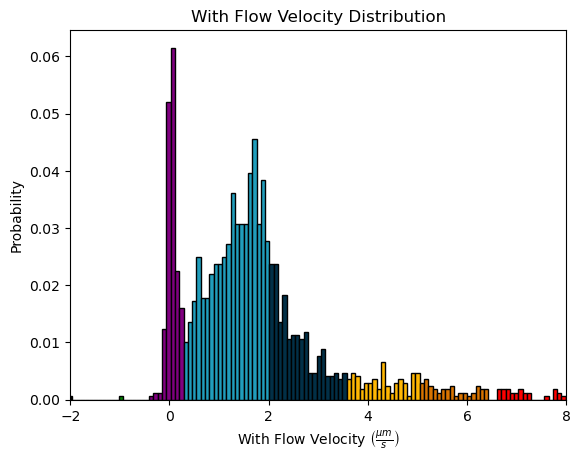

In [30]:
# Create Distribution Plots.
max_X_Display = 8
min_X_Display = -2
colors = ["#008000","#800080","#219ebc","#023047","#ffb703","#d97400", "#ff0000"]
color_Spacing = (max_X_Display - min_X_Display)/len(colors)
cutoffs = [-2,-0.5,0.25,2,3.5,5,6.5,8]
probability_Weights = np.ones_like(with_Flow_Velocities)/len(with_Flow_Velocities)
fig, ax = plt.subplots()

N, bins, patches = ax.hist(with_Flow_Velocities, edgecolor = "black", facecolor = "black", alpha = 1, bins = 200, weights = probability_Weights, lw = 1)

for i in range(len(cutoffs) - 1):
    for j in range(len(bins) - 1):
        if i < len(cutoffs) - 1:
            if bins[j] > cutoffs[i] and bins[j] < cutoffs[i + 1]:
                patches[j].set_facecolor(colors[i])
        else:
            if bins[j] > cutoffs[i]:
                patches[j].set_facecolor(colors[i])
            

plt.title("With Flow Velocity Distribution")
plt.xlabel("With Flow Velocity " + r"$\left(\frac{\mu m}{s}\right)$")
plt.ylabel("Probability")
plt.xlim(min_X_Display,max_X_Display)
plt.savefig(base_Directory + "Analysis/Outputs/Colored_Distributions.png")
plt.savefig(base_Directory + "Analysis/Outputs/Colored_Distributions.svg")
plt.show()

### You can run the following chunk of code to generate a tracks plot, showing trajectories of adhered cells during an experiment.

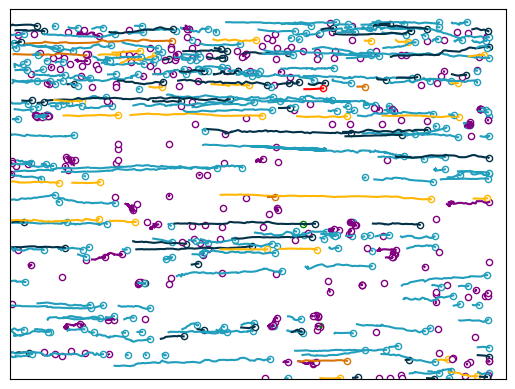

In [31]:
# Create Tracks Plot

fig, ax = plt.subplots()
vertical_Max = int(math.ceil(np.max(dynamic_Data["Vertical Position"])*microns_Per_Pixel / 100.0)) * 100
vertical_Min = int(math.ceil(np.min(dynamic_Data["Vertical Position"])*microns_Per_Pixel / 100.0)) * 100
horizontal_Max = int(math.ceil(np.max(dynamic_Data["Horizontal Position"])*microns_Per_Pixel / 100.0)) * 100
horizontal_Min = int(math.ceil(np.min(dynamic_Data["Horizontal Position"])*microns_Per_Pixel / 100.0)) * 100
plt.xlim(0,horizontal_Max)
plt.ylim(0,vertical_Max)
for cell_Number in unique_Cells[0:int(len(unique_Cells)/4)]:
#for cell_Number in np.arange(0,101,1):
    cell_Data = dynamic_Data[dynamic_Data["Cell Number"] == cell_Number]
    vertical_Positions = cell_Data["Vertical Position"].values*microns_Per_Pixel
    horizontal_Positions = cell_Data["Horizontal Position"].values*microns_Per_Pixel
    average_Velocity = -1*(horizontal_Positions[-1] - horizontal_Positions[0])/(len(cell_Data)*seconds_Per_Frame)
    #if np.abs(horizontal_Positions[-1] - horizontal_Positions[0]) > 1:
        #continue
    for j in range(len(cutoffs) - 1):
        if j < len(cutoffs) - 1:
            if average_Velocity > cutoffs[j] and average_Velocity < cutoffs[j + 1]:
                plt.plot(horizontal_Positions,vertical_Positions, color = colors[j], alpha = 1)
                plt.scatter(horizontal_Positions[0],vertical_Positions[0], facecolor = "white", edgecolor = colors[j], alpha = 1, s = 20)
        else:
            if average_Velocity > cutoffs[j]:
                plt.plot(horizontal_Positions,vertical_Positions, color = colors[j], alpha = 1)
                plt.scatter(horizontal_Positions[0],vertical_Positions[0], facecolor = "white", edgecolor = colors[j], alpha = 1, s = 20)
    #plt.text(horizontal_Positions[0] + 5,vertical_Positions[0] + 5,str(len(cell_Data)), size = 8)
ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig(base_Directory + "Analysis/Outputs/Tracks.png")
plt.savefig(base_Directory + "Analysis/Outputs/Tracks.svg")
plt.show()